#Installing Dataset

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
dataset_url = "https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset"
import opendatasets as od
od.download(dataset_url)

Skipping, found downloaded files in "./face-mask-12k-images-dataset" (use force=True to force download)


#Importing Libraries

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

#Initializing the Data

In [ ]:
data_path = "/content/face-mask-12k-images-dataset/Face Mask Dataset"
train_path = "/content/face-mask-12k-images-dataset/Face Mask Dataset/Train"
test_path = "/content/face-mask-12k-images-dataset/Face Mask Dataset/Test"
val_path = "/content/face-mask-12k-images-dataset/Face Mask Dataset/Validation"

Trasform data into tensors and some other transformations too..

In [ ]:
dataset = ImageFolder(data_path , tt.Compose([tt.Resize((224,224)),
                                              tt.RandomHorizontalFlip(),
                                              tt.ToTensor()
]))

train_ds = ImageFolder(train_path , tt.Compose([tt.Resize((224,224)),
                                              tt.RandomHorizontalFlip(),
                                              tt.ToTensor()
]))

val_ds = ImageFolder(val_path , tt.Compose([tt.Resize((224,224)),
                                              tt.RandomHorizontalFlip(),
                                              tt.ToTensor()
]))

test_ds = ImageFolder(test_path, tt.Compose([tt.Resize((224,224)),
                                              tt.RandomHorizontalFlip(),
                                              tt.ToTensor()]))

In [ ]:
len(dataset), len(train_ds), len(val_ds), len(test_ds)

(11792, 10000, 800, 992)

Convert Datasets into DataLoaders

In [ ]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=False, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Showing a batch of examples from the dataset...

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=12).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  WithMask (0)


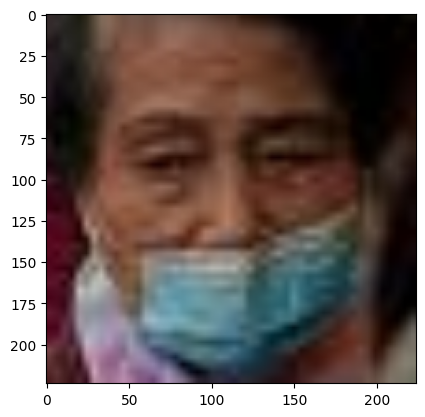

In [ ]:
show_example(*train_ds[2])

Classes are equaly distributed in all the datasets...

In [ ]:
mask = 0
face = 0
for i in train_dl:
    image,label = i
    for l in label:
        if train_ds.classes[l]=='WithMask':
            mask+=1
        else:
            face+=1
print('Face Label Images in Train Set:',face)
print('Mask Label Images in Train Set:',mask)

Face Label Images in Train Set: 5000
Mask Label Images in Train Set: 5000


In [ ]:
mask = 0
face = 0
for i in val_dl:
    image,label = i
    for l in label:
        if val_ds.classes[l]=='WithMask':
            mask+=1
        else:
            face+=1
print('Face Label Images in Validation Set:',face)
print('Mask Label Images in Validation Set:',mask)

Face Label Images in Validation Set: 400
Mask Label Images in Validation Set: 400


#Model

Designing a base class having all the step functions of training

In [ ]:
class Base(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        # print(f'Epoch: {epoch} | Train_loss: {result['train_loss']} | Val_loss:{result['val_loss']} | Val_acc: {result['val_acc']}')

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


Designing a class of Convolutional Neural Network derived from the Base Class

In [ ]:
class FaceMaskDetectionModel(Base):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.AdaptiveMaxPool2d(1),

            nn.Flatten(),
            nn.Linear(32, 2),
            )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = FaceMaskDetectionModel()
model

FaceMaskDetectionModel(
  (network): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

#GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Loading Dataloaders to the GPU

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

FaceMaskDetectionModel(
  (network): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

#Training

Now Define Training steps for the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(FaceMaskDetectionModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 0.6854544878005981, 'val_acc': 0.609375}

Training the model to get the best predictions and accuracy...

In [ ]:
lr = 0.001
num_epochs = 5
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.3039, val_loss: 0.2501, val_acc: 0.9033
Epoch [1], train_loss: 0.1622, val_loss: 0.1672, val_acc: 0.9434
Epoch [2], train_loss: 0.1224, val_loss: 0.2327, val_acc: 0.9043
Epoch [3], train_loss: 0.0984, val_loss: 0.1140, val_acc: 0.9561
Epoch [4], train_loss: 0.0839, val_loss: 0.0971, val_acc: 0.9756
CPU times: user 10 s, sys: 10.1 s, total: 20.1 s
Wall time: 2min 4s


#Visualization

Loss Graph

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

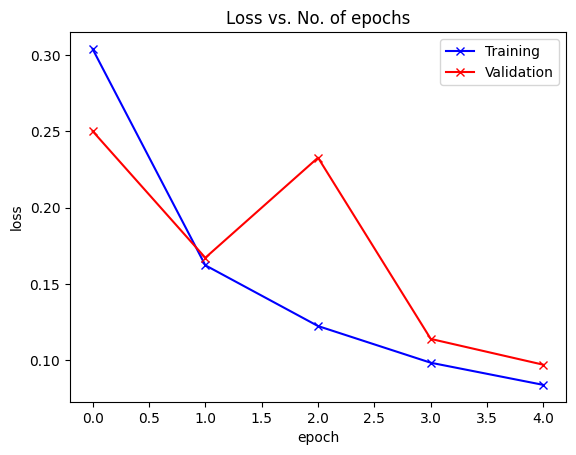

In [ ]:
plot_losses(history)

Accuracy Graph

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

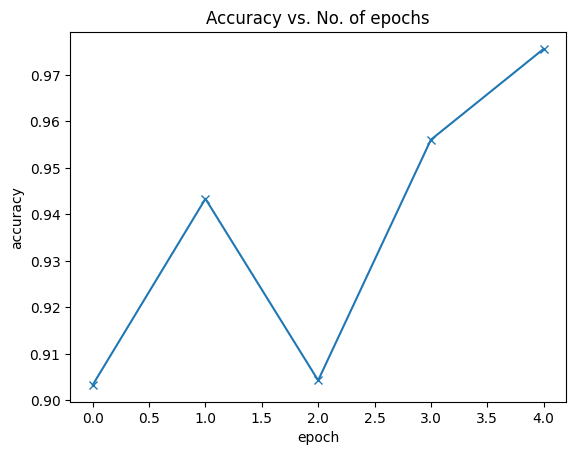

In [ ]:
plot_accuracies(history)

#Prediction

Testing the model's accuracy on Test Data by predicting some images..

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: WithMask , Predicted: WithMask


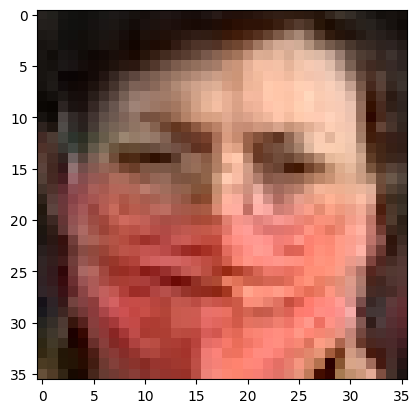

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

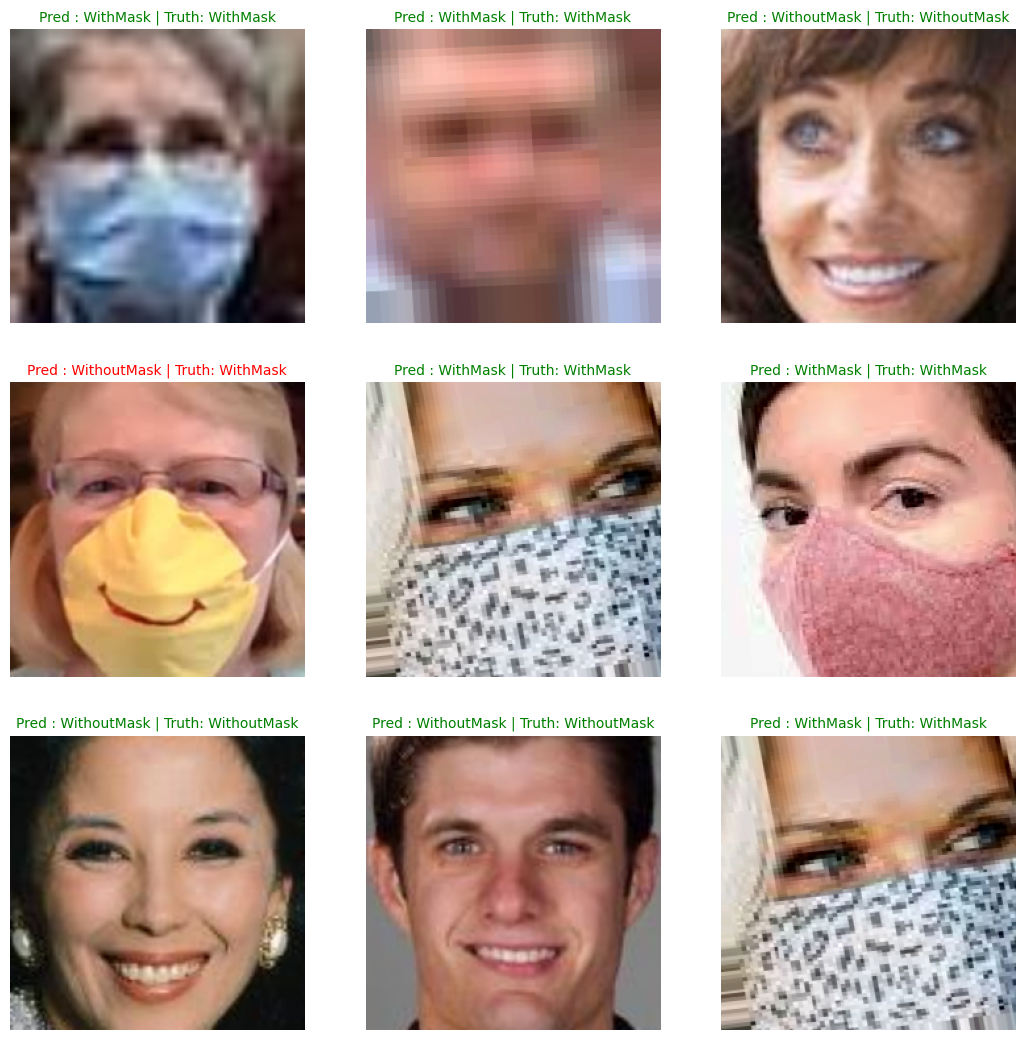

In [ ]:
# Get a batch of images from the train_loader
images, labels = next(iter(test_dl))

with torch.no_grad():
  predicted_labels = model(images.to(device))
  predicted_labels = torch.argmax(predicted_labels, 1)
rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5)
plt.figure(figsize = (13,13))

for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  pred_label = predicted_labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  # plt.title(f'Label: {test_ds.classes[label]}, Pred: {test_ds.classes[pred_label]}')
  title_text = f"Pred : {test_ds.classes[pred_label]} | Truth: {test_ds.classes[label]}"
  if pred_label == label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)

In [ ]:
torch.save(model.state_dict(), 'face-mask-detection.pth')